In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = '/content/drive/MyDrive/DIY/Tools_DIY_outdoor.csv'  # Update the path to your dataset
data = pd.read_csv(file_path)
reviews = data['Review']
sentiments = data['Sentiment']  # Assuming sentiments are labeled as 'Positive', 'Negative'

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

def encode_data(tokenizer, texts, max_length=256):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_text = tokenizer.encode_plus(
            text,
            max_length=max_length,
            add_special_tokens=True,
            return_attention_mask=True,
            pad_to_max_length=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_text['input_ids'])
        attention_masks.append(encoded_text['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

input_ids, attention_masks = encode_data(tokenizer, reviews)

# Convert sentiment labels to numerical form
label_map = {'Positive': 1, 'Negative': 0}  # Update this map based on your dataset's labels
labels = torch.tensor(sentiments.map(label_map).values)

# Split data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.2)

# Create DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=32)

model_name = 'bert-base-multilingual-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)


model.cuda()




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch
import numpy as np
import time
import datetime

# Check if a GPU is available and use it; otherwise, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Then, you can move your model to the chosen device
model = model.to(device)

# Training loop
epochs = 20
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Lists to store training loss values
train_loss_values = []

# Function to calculate elapsed time
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

print("")
print("Training complete!")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 20 ========
Training...
  Batch    40  of    167.    Elapsed: 0:00:48.
  Batch    80  of    167.    Elapsed: 0:01:37.
  Batch   120  of    167.    Elapsed: 0:02:27.
  Batch   160  of    167.    Elapsed: 0:03:18.

  Average training loss: 0.34
  Training epoch took: 0:03:26

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    167.    Elapsed: 0:00:50.
  Batch    80  of    167.    Elapsed: 0:01:40.
  Batch   120  of    167.    Elapsed: 0:02:31.
  Batch   160  of    167.    Elapsed: 0:03:21.

  Average training loss: 0.21
  Training epoch took: 0:03:29

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    167.    Elapsed: 0:00:50.
  Batch    80  of    167.    Elapsed: 0:01:40.
  Batch   120  of    167.    Elapsed: 0:02:31.
  Batch   160  of    167.    Elapsed: 0:03:21.

  Average training loss: 0.15
  Training epoch took: 0:03:29

======== Epoch 4 / 20 ========
Training...
  Batch    40  of    167.    Elapsed: 0:00:50.
  Batch    80  of    167.  

In [ ]:
import matplotlib.pyplot as plt

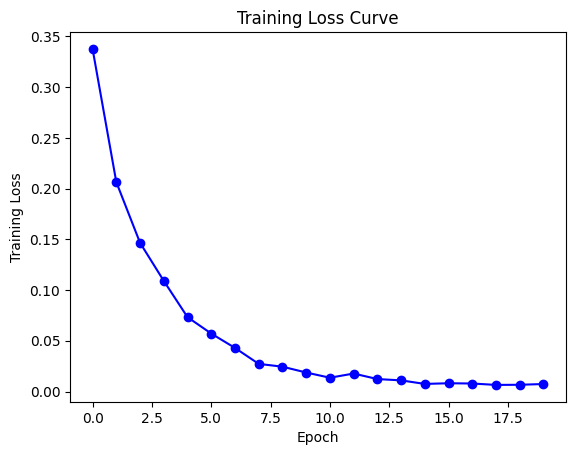

In [ ]:
# Plotting the training loss curve
plt.plot(train_loss_values, 'b-o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(validation_inputs)))

model.eval()

predictions, true_labels = [], []

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

print('DONE.')

# Flatten the predictions and true values for overall metrics
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the accuracy of our predictions
accuracy = accuracy_score(flat_true_labels, flat_predictions)

# Calculate the accuracy for each class
accuracy_positive = accuracy_score(flat_true_labels[flat_true_labels == 1], flat_predictions[flat_true_labels == 1])
accuracy_negative = accuracy_score(flat_true_labels[flat_true_labels == 0], flat_predictions[flat_true_labels == 0])

print('Accuracy - Negative: %.3f' % accuracy_negative)
print('Accuracy - Positive: %.3f' % accuracy_positive)

# Classification report for precision, recall, f1-score
report = classification_report(flat_true_labels, flat_predictions, target_names=['Negative', 'Positive'])

print('Accuracy: %.3f' % accuracy)
print('Classification Report:')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(flat_true_labels, flat_predictions)

print(report)
print(conf_matrix)


Predicting labels for 1,330 test sentences...
DONE.
Accuracy - Negative: 0.693
Accuracy - Positive: 0.949
Accuracy: 0.902
Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.69      0.72       244
    Positive       0.93      0.95      0.94      1086

    accuracy                           0.90      1330
   macro avg       0.84      0.82      0.83      1330
weighted avg       0.90      0.90      0.90      1330

[[ 169   75]
 [  55 1031]]
